In [44]:
# Install Prophet (do this only once)
!pip install prophet --quiet


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files


In [46]:
# Read CSV and preview
# Add the 'encoding' parameter to handle potential character encoding issues
try:
    df = pd.read_csv('/content/sales_data_sample.csv', encoding='utf-8')
except UnicodeDecodeError:
    # If utf-8 fails, try a different encoding like latin-1
    print("UTF-8 decoding failed, trying latin-1 encoding.")
    df = pd.read_csv('/content/sales_data_sample.csv', encoding='latin-1')

print("\n📄 First 5 rows of the dataset:")
print(df.head())
print("\n📊 Column names:", df.columns.tolist())

UTF-8 decoding failed, trying latin-1 encoding.

📄 First 5 rows of the dataset:
   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

         ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/2003 0:00  Shipped       1         2     2003  ...   
1    5/7/2003 0:00  Shipped       2         5     2003  ...   
2    7/1/2003 0:00  Shipped       3         7     2003  ...   
3   8/25/2003 0:00  Shipped       3         8     2003  ...   
4  10/10/2003 0:00  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0        897 Long Airport Avenue     

In [47]:
# Convert Date column and keep only Date and Sales
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce')
# Replace 'SALES_VALUE' with the actual column name for sales in your CSV
# For example, if the sales column is named 'SALES', change the line below to:
# df = df[['ORDERDATE', 'SALES']].dropna()
df = df[['ORDERDATE', 'SALES']].dropna() # <--- Change 'SALES_VALUE' to the actual sales column name
df = df.sort_values('ORDERDATE')
df = df.drop_duplicates()

# Rename for Prophet
# Replace the sales column name below with the actual column name you used above
# For example, if the sales column is named 'SALES', change the line below to:
# df = df.rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'})
df = df.rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'}) # <--- Change 'SALES_VALUE' to the actual sales column name

# Preview cleaned data
print("\n✅ Cleaned data sample:")
print(df.head())


✅ Cleaned data sample:
             ds        y
578  2003-01-06  5151.00
680  2003-01-06  3390.00
1267 2003-01-06  1903.22
2024 2003-01-06  1689.03
1539 2003-01-09  1404.00


<ipython-input-48-f7237d400051>:8: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


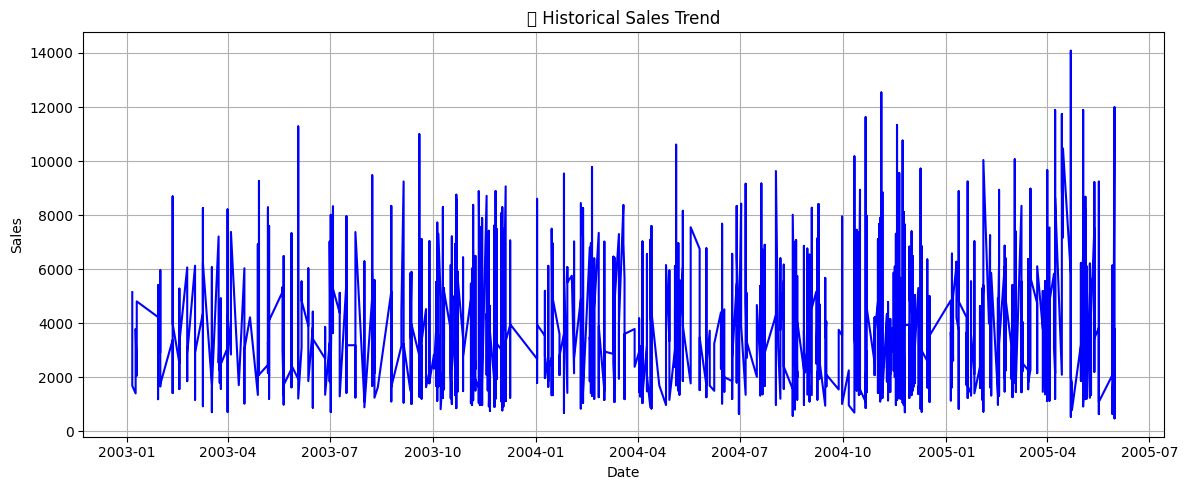

In [48]:
# Plot historical sales
plt.figure(figsize=(12,5))
plt.plot(df['ds'], df['y'], color='blue')
plt.title("📈 Historical Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
# Create and train the Prophet model
model = Prophet()
model.fit(df)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkpzq_pwl/l_d2vwl4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkpzq_pwl/sdmbzjt_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34591', 'data', 'file=/tmp/tmpkpzq_pwl/l_d2vwl4.json', 'init=/tmp/tmpkpzq_pwl/sdmbzjt_.json', 'output', 'file=/tmp/tmpkpzq_pwl/prophet_modelqxu5hvp7/prophet_model-20250518181448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [50]:
# Forecast the next 90 periods (days, weeks, or months depending on original frequency)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


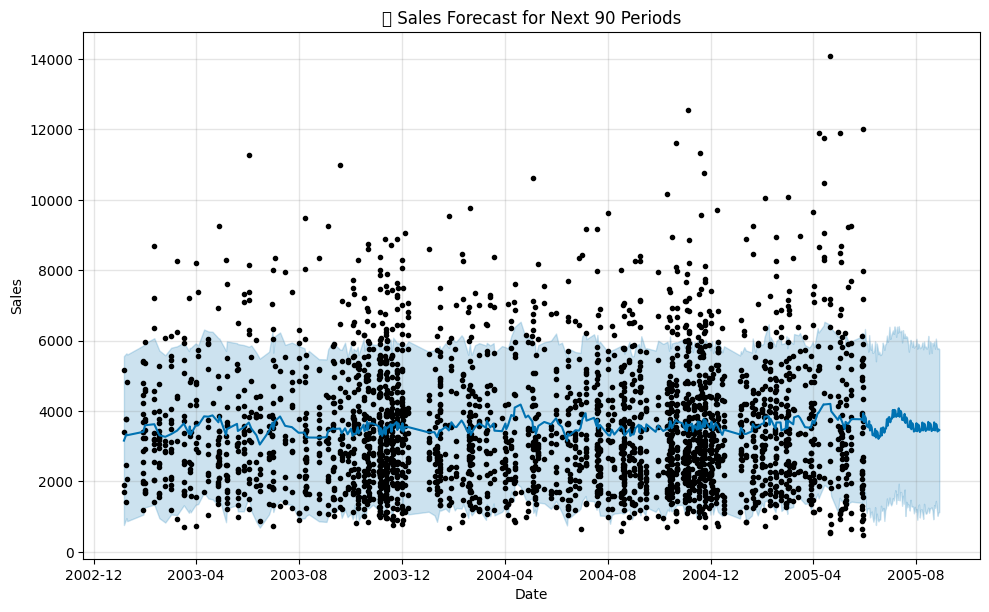

In [51]:
# Plot the sales forecast
fig1 = model.plot(forecast)
plt.title("🔮 Sales Forecast for Next 90 Periods")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


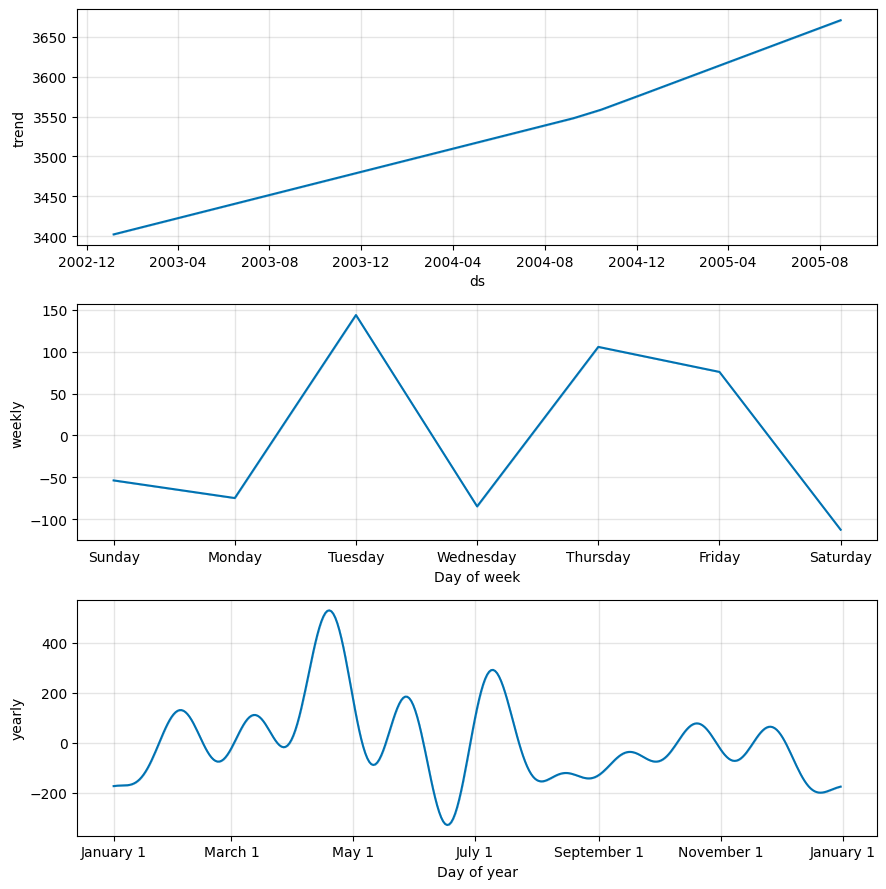

In [52]:
# Show components: trend, weekly seasonality, yearly seasonality (if present)
fig2 = model.plot_components(forecast)
plt.show()


In [53]:
# Merge actual and predicted values for overlapping dates
merged_df = pd.merge(df, forecast[['ds', 'yhat']], on='ds', how='inner')

# Calculate error metrics
mae = mean_absolute_error(merged_df['y'], merged_df['yhat'])
rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['yhat']))

print("\n📌 Forecast Accuracy Metrics:")
print(f"• Mean Absolute Error (MAE): {mae:.2f}")
print(f"• Root Mean Squared Error (RMSE): {rmse:.2f}")



📌 Forecast Accuracy Metrics:
• Mean Absolute Error (MAE): 1427.77
• Root Mean Squared Error (RMSE): 1833.73


In [54]:
# Export the forecast to CSV
forecast.to_csv("sales_forecast_output.csv", index=False)
files.download("sales_forecast_output.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>